In [2]:
import scanpy as sc
import pickle as pkl
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix

from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import scvi

#import torch
#torch.cuda.is_available()


True

In [28]:
TESTING=False

In [3]:
path_adata='/om2/user/khrovati/data/cross_system_integration/retina_adult_organoid/combined_HVG.h5ad'

In [4]:
group_key='cell_type'
batch_key='sample_id'
system_key='system'

In [32]:
adata=sc.read(path_adata)

In [33]:
# revert log
# Need to exp-1 only non-0 elements (others will result in 0 anyways)
adata.layers['normalized']=csr_matrix(
    (np.exp(adata.X.data)-1,adata.X.indices,adata.X.indptr),shape=adata.shape)

## Counts

In [34]:
adata_training = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata_training, 
    layer="counts", 
    batch_key=system_key,
    categorical_covariate_keys=[batch_key])

In [35]:
model = scvi.model.SCVI(adata_training, 
                        n_layers=2, n_hidden=256, n_latent=15, 
                        gene_likelihood="nb")
#model.to_device(0) # For some reason this does not work here automatically

max_epochs= 100 if not TESTING else 2
model.train(
    max_epochs = max_epochs,
)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [13:26<00:00,  8.06s/it, loss=740, v_num=1]


In [36]:
cells_eval=adata_training.obs_names if not TESTING else \
    np.random.RandomState(seed=0).permutation(adata_training.obs_names)[:1000]
print('N cells for eval:',cells_eval.shape[0])
embed = model.get_latent_representation(
    adata=adata_training[cells_eval,:],
    indices=None,
    batch_size=None, )
embed=sc.AnnData(embed,obs=adata_training[cells_eval,:].obs)
# Make system categorical for metrics and plotting
embed.obs[system_key]=embed.obs[system_key].astype(str)
# neigh
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)

N cells for eval: 97996
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Epoch 3/100:   2%|▏         | 2/100 [14:54<12:10:22, 447.17s/it, loss=748, v_num=1]


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


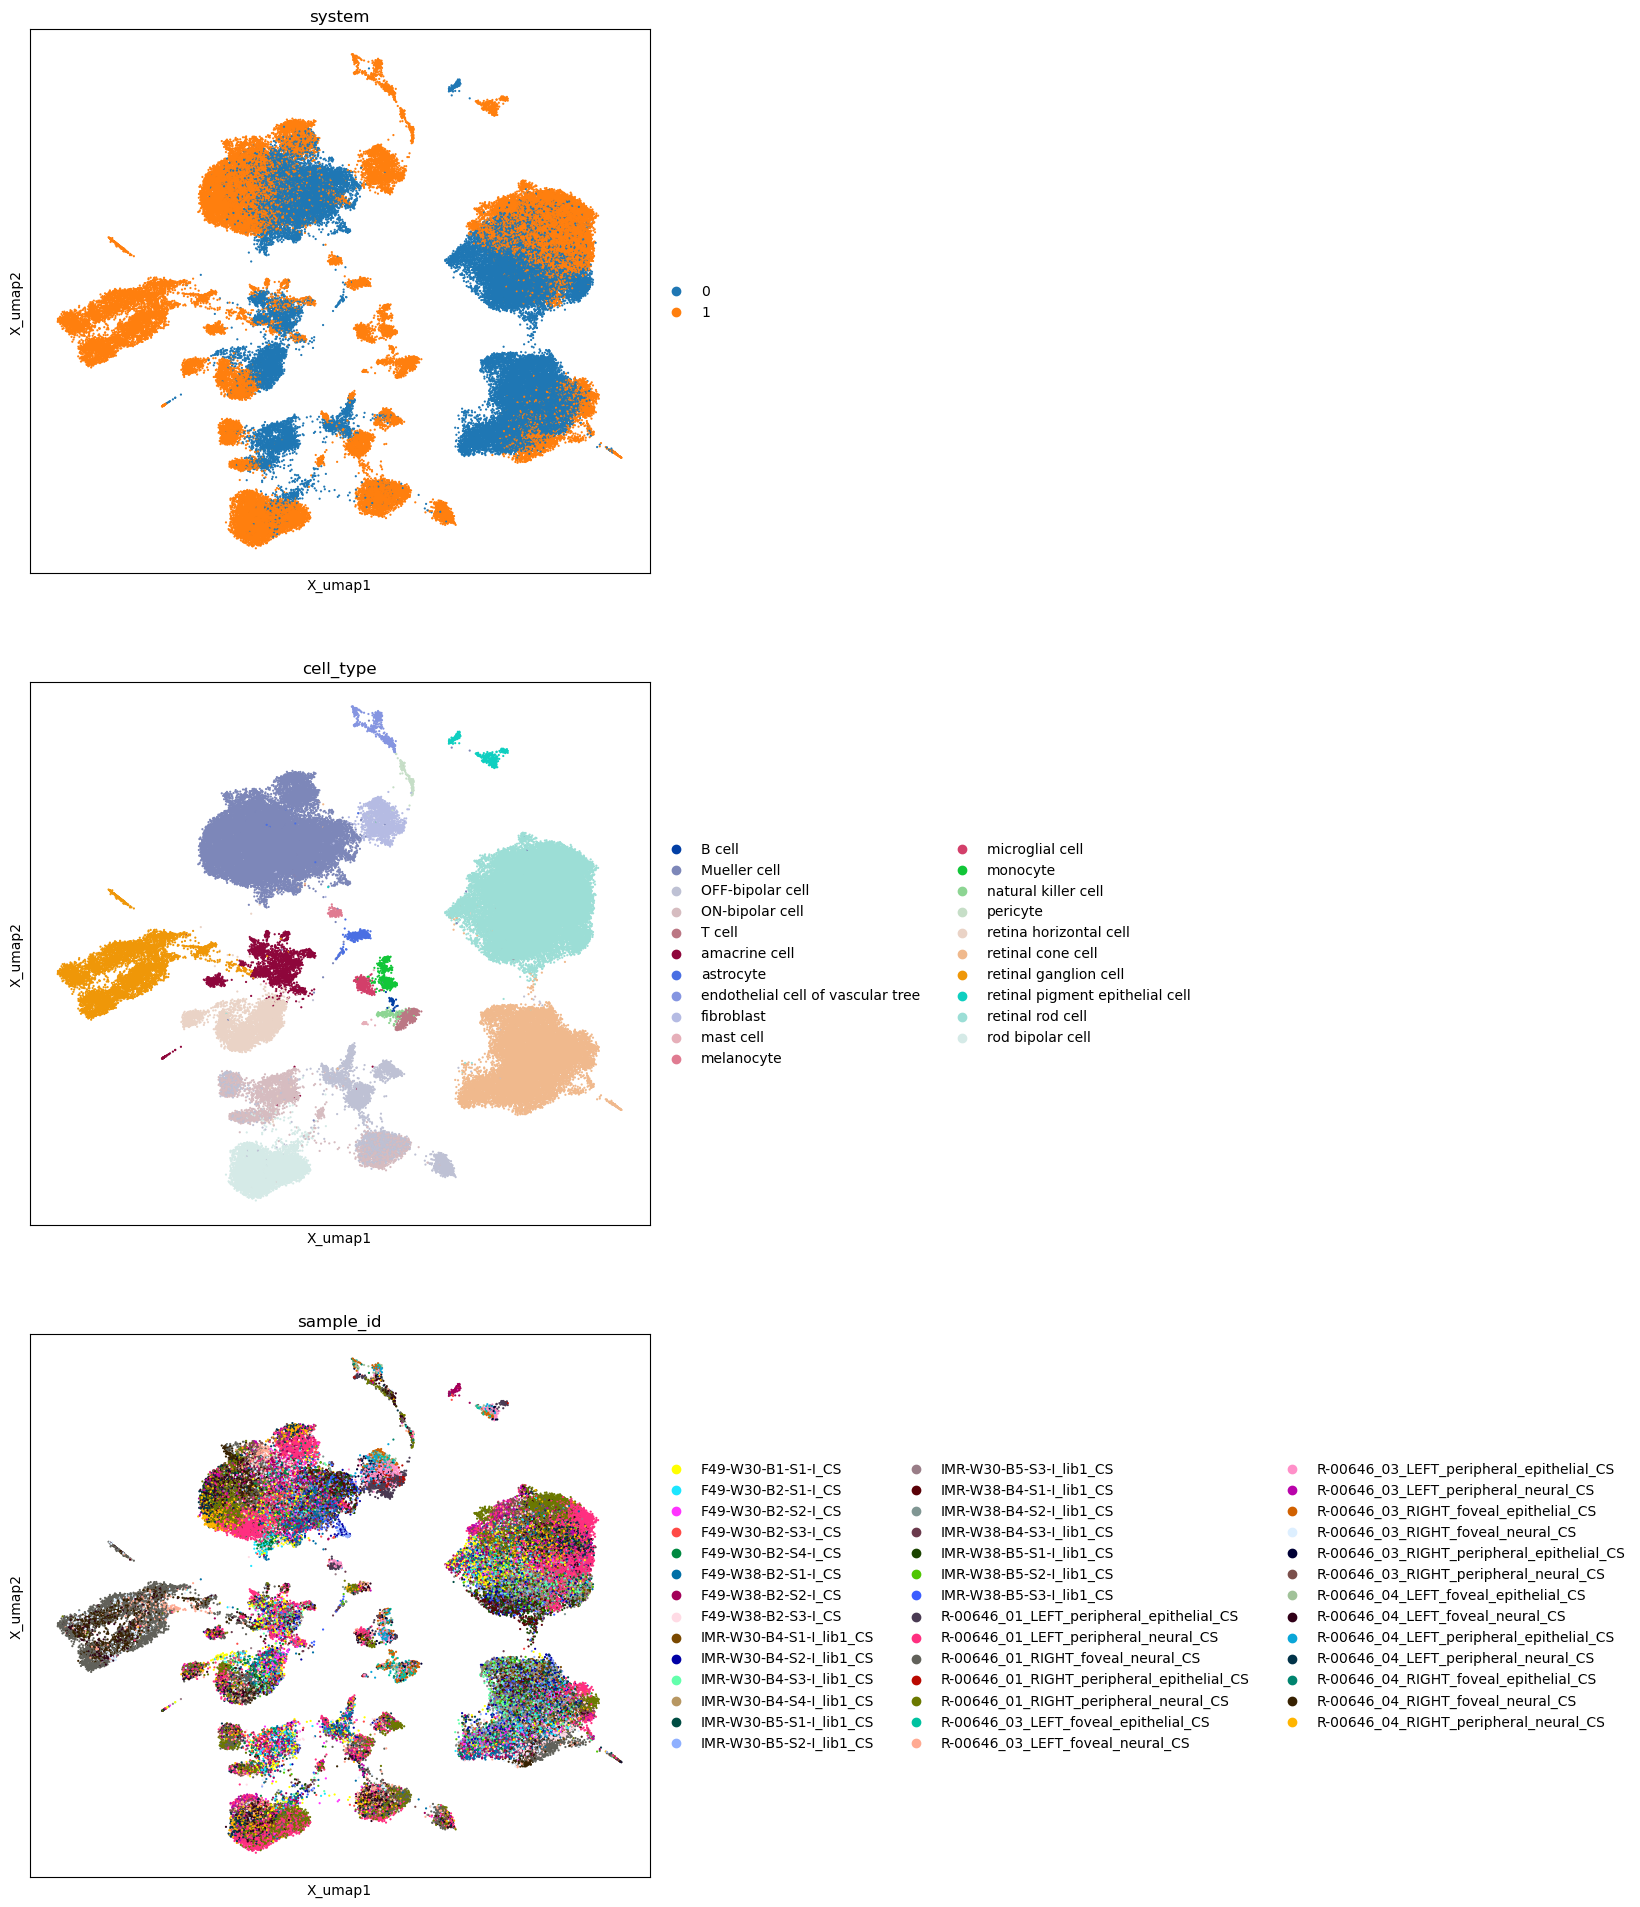

In [43]:
rcParams['figure.figsize']=(8,8)
cols=[system_key,group_key,batch_key]
np.random.seed(0)
random_idx=np.random.permutation(embed.obs_names)
fig,axs=plt.subplots(len(cols),1,figsize=(8,8*len(cols)))
for col,ax in zip(cols,axs):
    sc.pl.embedding(embed[random_idx],'X_umap',color=col,s=10,ax=ax,show=False,sort_order=False)

## Normalized

In [44]:
adata_training = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata_training, 
    layer="normalized", 
    batch_key=system_key,
    categorical_covariate_keys=[batch_key])

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[normalized] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [45]:
model = scvi.model.SCVI(adata_training, 
                        n_layers=2, n_hidden=256, n_latent=15, 
                        gene_likelihood="nb")
#model.to_device(0) # For some reason this does not work here automatically

max_epochs= 100 if not TESTING else 2
model.train(
    max_epochs = max_epochs,
)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [13:24<00:00,  8.05s/it, loss=1.14e+03, v_num=1]


In [46]:
cells_eval=adata_training.obs_names if not TESTING else \
    np.random.RandomState(seed=0).permutation(adata_training.obs_names)[:1000]
print('N cells for eval:',cells_eval.shape[0])
embed = model.get_latent_representation(
    adata=adata_training[cells_eval,:],
    indices=None,
    batch_size=None, )
embed=sc.AnnData(embed,obs=adata_training[cells_eval,:].obs)
# Make system categorical for metrics and plotting
embed.obs[system_key]=embed.obs[system_key].astype(str)
# neigh
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)

N cells for eval: 97996
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[normalized] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify

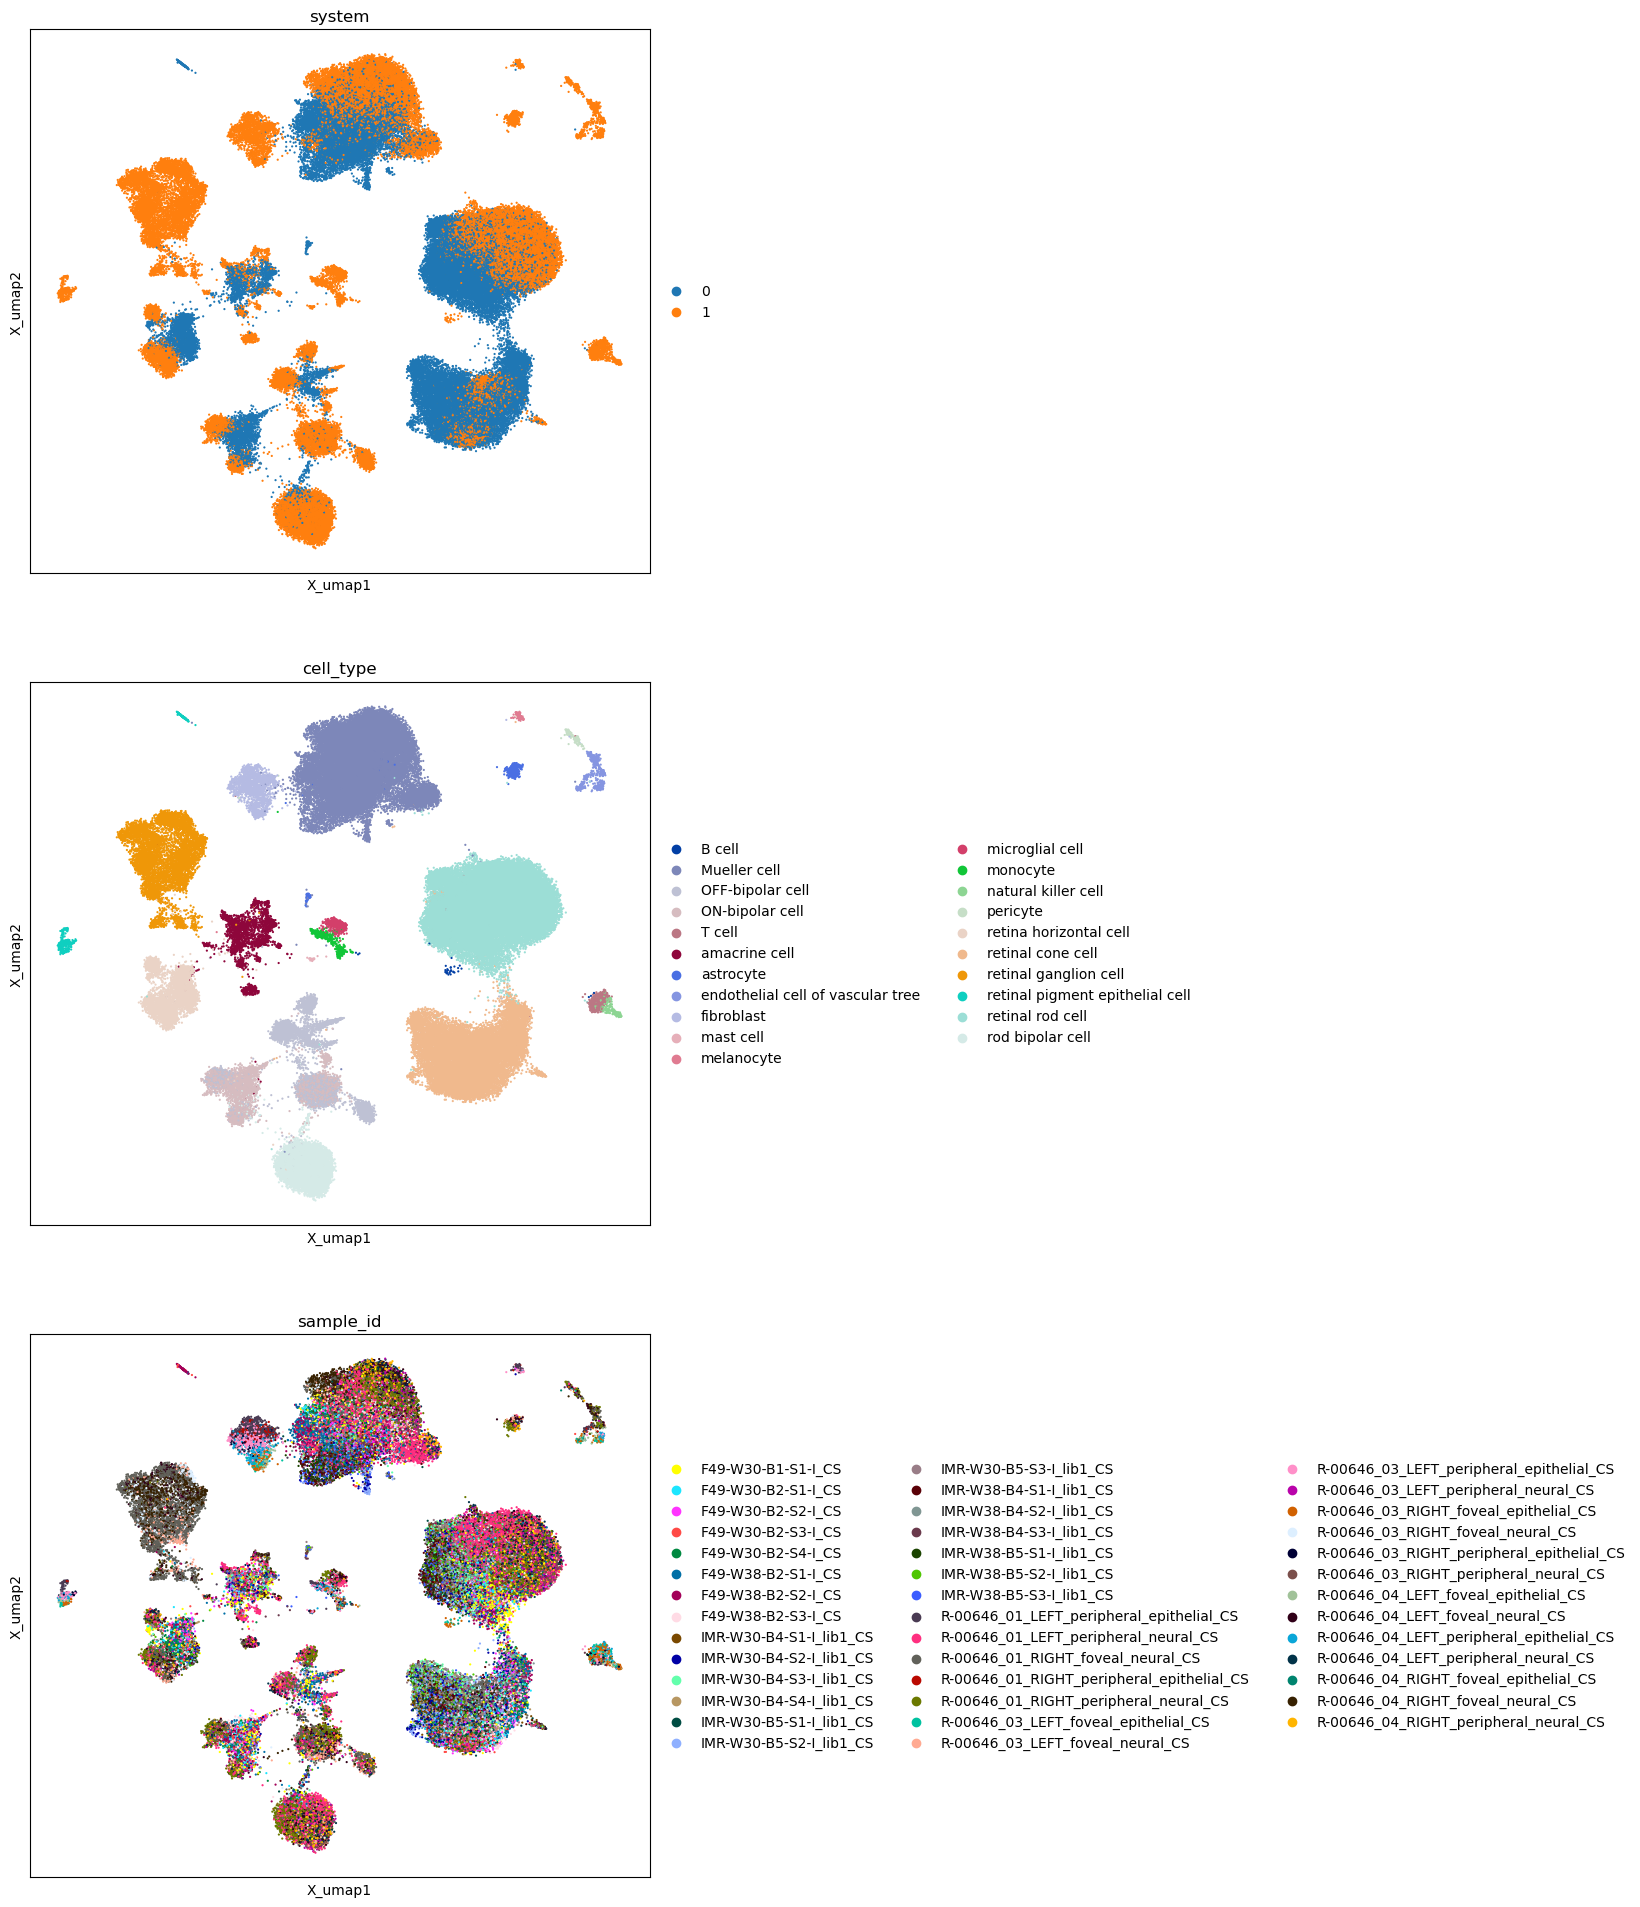

Epoch 13/100:  12%|█▏        | 12/100 [22:59<2:48:38, 114.99s/it, loss=1.14e+03, v_num=1]

In [47]:
rcParams['figure.figsize']=(8,8)
cols=[system_key,group_key,batch_key]
np.random.seed(0)
random_idx=np.random.permutation(embed.obs_names)
fig,axs=plt.subplots(len(cols),1,figsize=(8,8*len(cols)))
for col,ax in zip(cols,axs):
    sc.pl.embedding(embed[random_idx],'X_umap',color=col,s=10,ax=ax,show=False,sort_order=False)

C: Seems like normalization does not make a difference in scIV